In [1]:
import simpy

In [2]:
from metrics import MetricsCollector, MetricsMonitor
from simulation_actors import Submitter, JobScheduler, PoolManager
from simulation_components import JobQueue, InstancePool, EC2Service

In [3]:
POOL_MGR_HIGH_THRESHOLD = 0.85
POOL_MGR_LOW_THRESHOLD = 0.65
POOL_MGR_SCALEUP_COOL_DOWN = 3
POOL_MGR_SCALEDOWN_COOL_DOWN = 10
POOL_MGR_SCALE_UP_AMOUNT = 45
POOL_MGR_SCALE_DOWN_AMOUNT = 5


In [4]:
def run_simulation(simulation_time: int):
    """
    Sets up and runs the job execution simulation.
    """
    # 1. Setup Environment
    env = simpy.Environment()

    # 2. Create Core Components
    metrics = MetricsCollector()
    job_queue = JobQueue()
    instance_pool = InstancePool(env)
    ec2_service = EC2Service(env, provisioning_delay=5, deprovisioning_delay=2)

    # 3. Create Actors
    # Monitor to periodically record metrics
    MetricsMonitor(env, job_queue, instance_pool, metrics)

    # Submitters to generate jobs
    Submitter(
        env,
        job_queue,
        color="red",
        max_jobs_per_tick=2,
        max_instances_per_job=8,
        tags={},
    )
    Submitter(
        env,
        job_queue,
        color="blue",
        max_jobs_per_tick=1,
        max_instances_per_job=16,
        tags={},
    )

    # Job Scheduler to assign jobs to instances
    JobScheduler(env, job_queue, instance_pool, metrics)

    # Pool Manager to autoscale the instance pool
    PoolManager(
        env,
        instance_pool,
        job_queue,
        ec2_service,
        high_threshold=POOL_MGR_HIGH_THRESHOLD,
        low_threshold=POOL_MGR_LOW_THRESHOLD,
        scale_up_cooldown=POOL_MGR_SCALEUP_COOL_DOWN,
        scale_down_cooldown=POOL_MGR_SCALEDOWN_COOL_DOWN,
        scale_up_amount=POOL_MGR_SCALE_UP_AMOUNT,
        scale_down_amount=POOL_MGR_SCALE_DOWN_AMOUNT,
    )

    # 4. Run the simulation
    print(f"--- Starting simulation for {simulation_time} time steps ---")
    env.run(until=simulation_time)
    print("--- Simulation finished ---")

    # 5. Return collected metrics
    return metrics

--- Starting simulation for 200 time steps ---
--- Simulation finished ---

--- Simulation Summary ---
Total Jobs Completed: 256
Average Job Wait Time: 12.67
Average Pool Utilization: 79.69%
Queue Stability (Starts/Submissions): 165.00%
Control System Stability (Avg Demand/Avg Capacity): 37.28%
Total Time in Gridlock: 59 steps
Max Queue Lengths:
  - Total: 39
  - Red: 25
  - Blue: 20
--------------------------

--- Generating plots ---


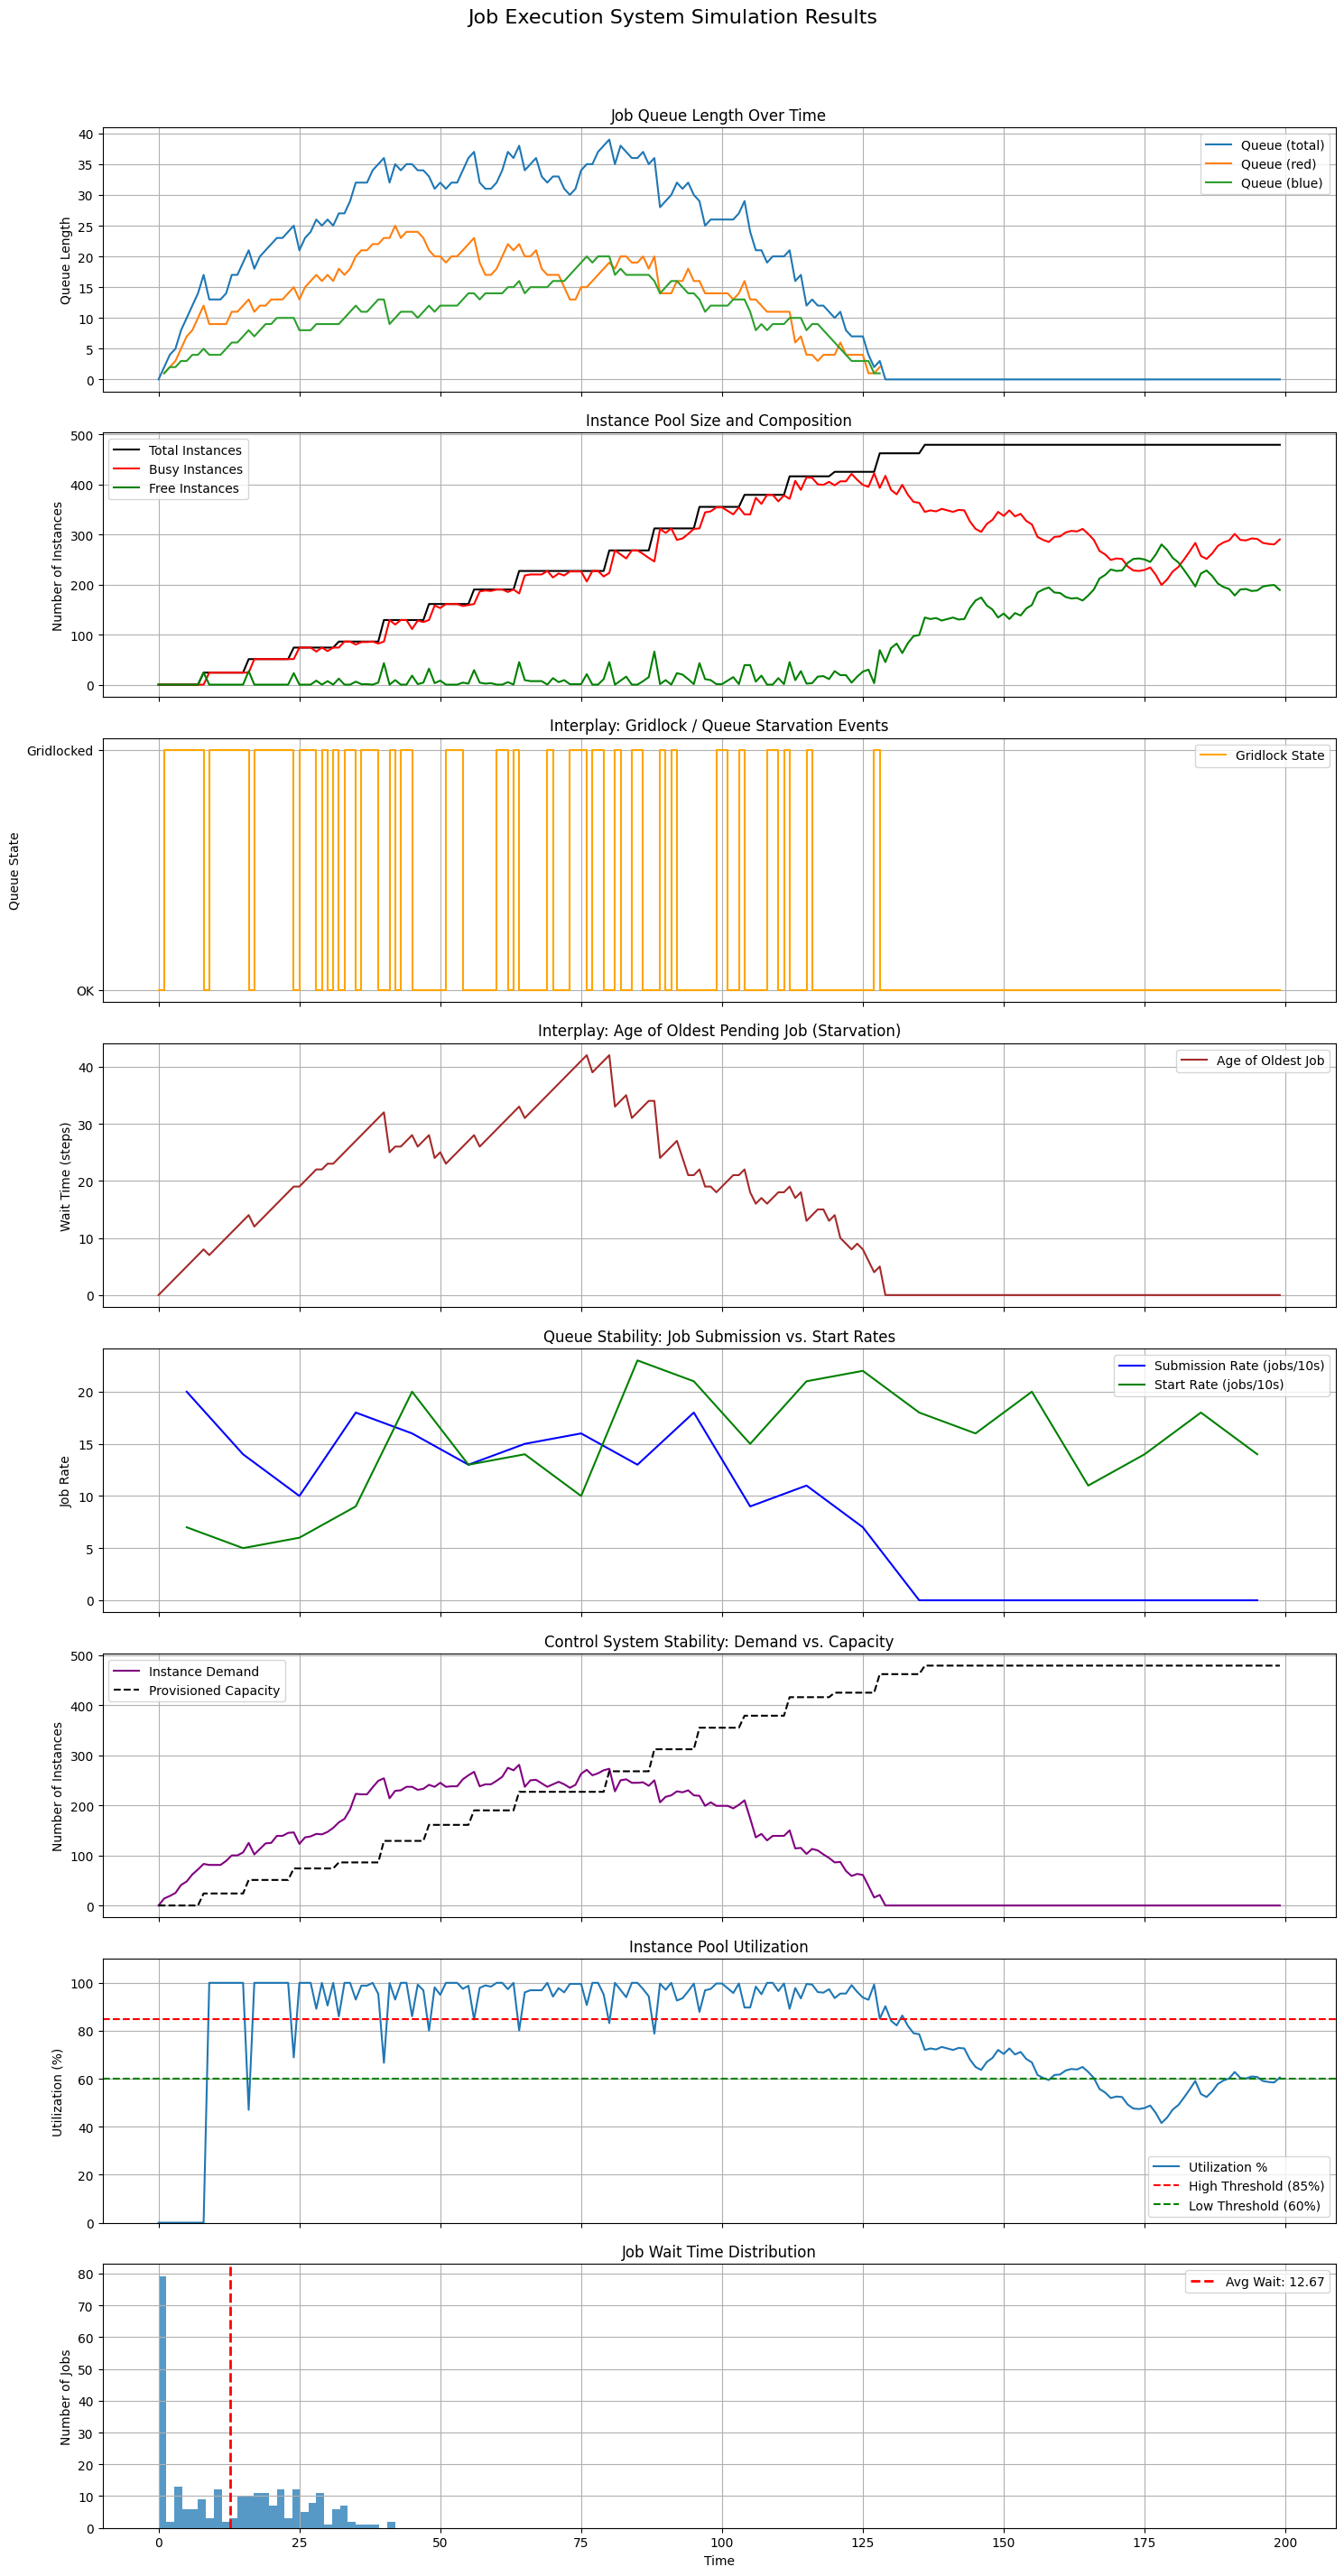

In [5]:
# --- Simulation Parameters ---
SIMULATION_TIME = 200

# --- Run Simulation ---
metrics_reporter = run_simulation(SIMULATION_TIME)

# --- Print Summary and Plot Results ---
metrics_reporter.print_summary()
metrics_reporter.plot()